Code to reproduce running example of [LPJ19].

[LPJ19] B. Legat, P. A. Parrilo and R. M. Jungers  **An entropy-based bound for the computational complexity of a switched system**. IEEE Transactions on Automatic Control, https://doi.org/10.1109/TAC.2019.2902625

We start by defining the constrained switched system using [HybridSystems](https://github.com/blegat/HybridSystems.jl/).
As it is one of the examples, we can just include this example. See the `PEDJ16s4.jl` file in the `examples` folder of that package for more details.

In [2]:
using HybridSystems
include(joinpath(dirname(dirname(pathof(HybridSystems))), "examples", "PEDJ16s4.jl"))

┌ Info: Recompiling stale cache file /home/blegat/.julia/compiled/v1.1/HybridSystems/omX1S.ji for HybridSystems [2207ec0c-686c-5054-b4d2-543502888820]
└ @ Base loading.jl:1184
┌ Info: Precompiling SwitchOnSafety [ceb7f16a-07bf-5f4a-9354-b68f01b1610f]
└ @ Base loading.jl:1186


The method presented in [LPJ19] solves a Set Program which is reformulated by [SetProg.jl](https://github.com/blegat/SetProg.jl) into Sum-of-Squares Program (SOSP) which is then reformulated by [SumOfSquares.jl](https://github.com/JuliaOpt/SumOfSquares.jl) into a SemiDefinie Program (SDP) which can then be solved through [JuMP](https://github.com/JuliaOpt/JuMP.jl) by any SDP solver implementing the [MathOptInterface](https://github.com/JuliaOpt/MathOptInterface.jl).
The SDP solver we use in this notebook is [Mosek](https://www.mosek.com/) even if any other SDP solver may be used.

In [3]:
using SwitchOnSafety
using MosekTools
factory = with_optimizer(Mosek.Optimizer, QUIET=true)

┌ Info: Recompiling stale cache file /home/blegat/.julia/compiled/v1.1/MosekTools/UJwlm.ji for MosekTools [1ec41992-ff65-5c91-ac43-2df89e9693a4]
└ @ Base loading.jl:1184


OptimizerFactory(Mosek.Optimizer, (), Base.Iterators.Pairs(:QUIET=>true))

To determine $\rho_{\text{SOS-}2d}$, we solve Program 1 using a bisection method on $\overline{\gamma}$.
Around $\rho_{\text{SOS-}2d}$, the problem is ill-posed so the solver will have numerical difficulties.
We use a tolerance of $3 \times 10^{-7}$. The tolerance needs to be large enough so that the solver does not have numerical issues and small enough so that we see which entries of the infeasibility certificate are numerically zero.

In [6]:
using MultivariateMoments
using LightGraphs
using LinearAlgebra

function prune_lyap(d, factory; tol=3e-7, threshold=2e-4)
    # We solve Program 1 by bisection.
    soslb, sosub = soslyapb(hs, d, factory=factory, tol=tol)
    G = copy(hs.automaton.G)
    # We obtain here the infeasibility certificate.
    dual = getlyap(hs, d).dual
    # We try here to determine which entries of the infeasibility
    # certificate are almost zero.
    μs = map(t -> norm(dual[t].Q.Q, Inf), transitions(hs))
    maxμs = maximum(μs)
    min_kept = Inf
    max_left = 0.0
    @show sort(μs / maxμs)
    for (i, t) in enumerate(transitions(hs))
        # We normalize because an infeasibility certificate
        # is a ray so it could have any scaling.
        x = μs[i] / maxμs
        if x < threshold
            max_left = max(max_left, x)
            rem_edge!(G, t.edge)
        else
            min_kept = min(min_kept, x)
        end
    end
    # This allows to see if the threshold was well chosen
    println(max_left, " < ", threshold, " < ", min_kept)
    return soslb, sosub, ρ(adjacency_matrix(G))
end

prune_lyap (generic function with 1 method)

As we can see below, there is a gap between the entries of the infeasibility certificates with norms around $10^{-6}$ and those with norms around unity. The `threshold` $2 \times 10^{-4}$ seems to appropriately select the edges with numerically zero infeasibility certificate.

In [7]:
sosb = prune_lyap.(1:6, Ref(factory))

sort(μs / maxμs) = [3.82951e-7, 4.89884e-7, 6.50315e-7, 6.62128e-7, 8.16912e-7, 8.43434e-7, 0.644312, 0.942364, 1.0]
8.43434135755067e-7 < 0.0002 < 0.6443119643325338
sort(μs / maxμs) = [6.38436e-7, 8.13757e-7, 9.72646e-7, 1.32941e-6, 1.9136e-6, 2.74022e-6, 0.176517, 0.42859, 1.0]
2.740218466337836e-6 < 0.0002 < 0.1765168798324311
sort(μs / maxμs) = [1.03015e-6, 1.19841e-6, 1.42536e-6, 4.18464e-6, 0.0601089, 0.110974, 0.120978, 0.24618, 1.0]
4.184640701603601e-6 < 0.0002 < 0.06010887320090561
sort(μs / maxμs) = [2.58109e-7, 7.85543e-7, 1.02583e-6, 1.0358e-6, 0.0331839, 0.228945, 0.390375, 0.494206, 1.0]
1.0357991468345856e-6 < 0.0002 < 0.03318390522289925
sort(μs / maxμs) = [1.57022e-6, 1.72952e-6, 2.17106e-6, 2.17575e-6, 0.0164789, 0.161922, 0.305794, 0.412272, 1.0]
2.175745402566825e-6 < 0.0002 < 0.01647893732896833
sort(μs / maxμs) = [1.11441e-6, 3.2938e-6, 3.64918e-6, 5.23258e-6, 0.00836874, 0.127531, 0.222401, 0.334751, 1.0]
5.232584323885028e-6 < 0.0002 < 0.008368742251479206


6-element Array{Tuple{Float64,Float64,Float64},1}:
 (0.7096199402330368, 1.0035543230574266, 1.618033988749895)
 (0.7753990260138268, 0.9863230324613662, 1.618033988749895)
 (0.8321070828192696, 0.9768814637887235, 1.83928675521416) 
 (0.8644570590955903, 0.974968172813975, 1.83928675521416)  
 (0.8854899009453173, 0.9749474883660003, 1.83928675521416) 
 (0.8997628268765168, 0.9748985479159743, 1.83928675521416) 

We can compute several different lower bounds from the upper bound found above using techniques developed in [LPJ19].

In [8]:
soslb = map(x -> x[1], sosb)
sosub = map(x -> x[2], sosb)
ρG = ρ(adjacency_matrix(hs.automaton.G))
@show ρG
bi(d) = binomial(2+d-1,d)
m = HybridSystems.ntransitions(hs)
@show m
# Theorem 2
soslbρ = map(x -> x[2][2]/(ρG^(1/(2x[1]))), enumerate(sosb))
# Theorem 3
soslbn = map(x -> x[2][2]/(bi(x[1])^(1/(2x[1]))), enumerate(sosb))
# Theorem 4
sosllb = map(x -> x[2][2]/(x[2][3]^(1/(2x[1]))), enumerate(sosb))
# Kronecker lift
soslbm = map(x -> x[2][2]/(m^(1/(2x[1]))), enumerate(sosb))
bi.(1:6)

ρG = 2.618033988749896
m = 9


6-element Array{Int64,1}:
 2
 3
 4
 5
 6
 7

As show in Lemma 2 of [LPJ19], the $2d$-radius provides lower and upper bounds to the CJSR given in equation (12) of [LPJ19].
We compute the $2d$-radius below with $d$ up to 6.

In [23]:
sosprl = zeros(6)
sospru = zeros(6)
# sospru = sosprl .* (SwitchOnSafety.ρA(hs) .^ (1 ./ (2:2:12)))
for i in 1:6
    @time sosprl[i], sospru[i] = pradiusb(hs, 2*i, VeroneseLift())
end

  0.008467 seconds (1.40 k allocations: 133.781 KiB)
  0.000592 seconds (2.46 k allocations: 230.672 KiB)
  0.000815 seconds (4.14 k allocations: 391.250 KiB)
  0.001178 seconds (6.43 k allocations: 621.203 KiB)
  0.001856 seconds (9.43 k allocations: 932.344 KiB)
  0.002796 seconds (13.15 k allocations: 1.294 MiB)


We display below all the values obtained:

In [24]:
[soslb'; sosub'; soslbρ'; soslbn'; sosllb'; soslbm'; sosprl'; sospru']

8×6 Array{Float64,2}:
 0.70962   0.775399  0.832107  0.864457  0.88549   0.899763
 1.00355   0.986323  0.976881  0.974968  0.974947  0.974899
 0.620231  0.775399  0.832107  0.864457  0.88549   0.899763
 0.70962   0.749443  0.775351  0.797295  0.815016  0.828962
 0.788946  0.874525  0.882538  0.903461  0.91731   0.926628
 0.334518  0.569454  0.677332  0.740816  0.782631  0.811782
 0.879075  0.893726  0.904888  0.913522  0.920342  0.925834
 1.42237   1.13684   1.06233   1.0303    1.01332   1.00315 

Values computed with Mosek v8.1.0.67 are as follows:

| d      | 1        | 2        | 3        | 4        | 5        | 6        |
|:------:|:--------:|:--------:|:--------:|:--------:|:--------:|:--------:|
| soslb  | 0.70962  | 0.775399 | 0.832107 | 0.864457 | 0.88549  | 0.899763 |
| sosub  | 1.00355  | 0.986323 | 0.976881 | 0.974968 | 0.974948 | 0.974901 |
| soslbρ | 0.620231 | 0.775399 | 0.832107 | 0.864457 | 0.88549  | 0.899765 |
| soslbn | 0.70962  | 0.749443 | 0.775351 | 0.797295 | 0.815016 | 0.828964 |
| sosllb | 0.788946 | 0.874525 | 0.882538 | 0.903461 | 0.91731  | 0.92663  |
| soslbm | 0.334518 | 0.569454 | 0.677332 | 0.740815 | 0.782631 | 0.811783 |
| sosprl | 0.879075 | 0.893726 | 0.904888 | 0.913522 | 0.920342 | 0.925834 |
| sospru | 1.422373 | 1.136836 | 1.062325 | 1.030305 | 1.013320 | 1.003147 |

Computing the $2d$-radius would be a lot slower with Kronecker lifts than with Veronese lifts.
This is because matrices obtained by veronese lifting are the "symmetry-reduced version of the $d$-fold Kronecker product" [PJ08].

[PJ08] P. Parrilo and A. Jadbabaie.
*Approximation of the joint spectral radius using sum of squares*.
Linear Algebra and its Applications, Elsevier, **2008**, 428, 2385-2402

In [71]:
i = 6
@time sosprl[i], sospru[i] = pradiusb(hs, 2*i, KroneckerLift())

 10.127331 seconds (1.52 k allocations: 1.918 GiB, 5.91% gc time)


(0.9258342753832846, 1.003146883295951)

Using the results obtained above, we can now reproduce the Figure 3 of [LPJ19].


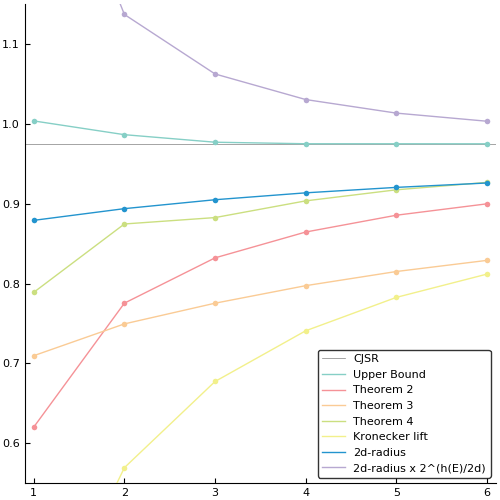

In [98]:
using Plots
pyplot()
xlims = (0.9, 6.1)
plot(size=(500, 500), xlims=xlims, ylims=(0.55, 1.15), legend=:bottomright, grid=false)
jsr = 0.9748171979372074
plot!(collect(xlims), [jsr, jsr], color=:grey, linewidth=.5, label="CJSR")
# colors taken from https://previews.123rf.com/images/capacitorphoto/capacitorphoto1410/capacitorphoto141000191/32438941-Graph-Icon-color-set-illustration--Stock-Vector.jpg
red = Plots.RGBA(((0xf5, 0x92, 0x97) ./ 255)...)
gre = Plots.RGBA(((0xcb, 0xdf, 0x80) ./ 255)...)
blu = Plots.RGBA(((0x23, 0x94, 0xce) ./ 255)...)
ora = Plots.RGBA(((0xfa, 0xcb, 0x95) ./ 255)...)
yel = Plots.RGBA(((0xf2, 0xf0, 0x8b) ./ 255)...)
pur = Plots.RGBA(((0xb7, 0xa8, 0xd1) ./ 255)...)
eme = Plots.RGBA(((0x86, 0xcf, 0xc6) ./ 255)...)
function _plot!(bound, col, name)
    plot!(1:6, bound, label=name, color=col)
    scatter!(1:6, bound, label="", markerstrokewidth=0, color=col)
end
_plot!(sosub, eme, "Upper Bound")
_plot!(soslbρ, red, "Theorem 2")
_plot!(soslbn, ora, "Theorem 3")
_plot!(sosllb, gre, "Theorem 4")
_plot!(soslbm, yel, "Kronecker lift")
_plot!(sosprl, blu, "2d-radius")
_plot!(sospru, pur, "2d-radius x 2^(h(E)/2d)")

We save this figure in the `results` folder on [codeocean](https://help.codeocean.com/getting-started/uploading-code-and-data/saving-files).

In [ ]:
Plots.savefig("../results/Figure_3.eps");